# Intermediate Machine Learning: Assignment 5

**Deadline**

Assignment 5 is due Wednesday, December 6 by 11:59pm. Late work will not be accepted as per the course policies (see the Syllabus and Course policies on Canvas).

Directly sharing answers is not okay, but discussing problems with the course staff or with other students is encouraged.

You should start early so that you have time to get help if you're stuck. The drop-in office hours schedule can be found on Canvas. You can also post questions or start discussions on Ed Discussion. The assignment may look long at first glance, but the problems are broken up into steps that should help you to make steady progress.

**Submission**

Submit your assignment as a pdf file on Gradescope, and as a notebook (.ipynb) on Canvas. You can access Gradescope through Canvas on the left-side of the class home page. The problems in each homework assignment are numbered. Note: When submitting on Gradescope, please select the correct pages of your pdf that correspond to each problem. This will allow graders to more easily find your complete solution to each problem.

To produce the .pdf, please do the following in order to preserve the cell structure of the notebook:

Go to "File" at the top-left of your Jupyter Notebook
Under "Download as", select "HTML (.html)"
After the .html has downloaded, open it and then select "File" and "Print" (note you will not actually be printing)
From the print window, select the option to save as a .pdf

**Topics**

 * RNNs and GRUs
 * Transformers

This assignment will also help to solidify your Python skills.

## Problem 1: Elephants Can Remember (25 points)



![ECR](https://upload.wikimedia.org/wikipedia/en/e/e3/Elephants_can_Remember_First_Edition_Cover_1972.jpg) 

In this problem, we will work with "vanilla" Recurrent Neural Networks (RNNs) and Recurrent Neural Networks with Gated Recurrent Units (GRUs). The models in this part of the assignment will be character-based models, trained on an extract of the book [Elephants Can Remember](https://en.wikipedia.org/wiki/Elephants_Can_Remember) by Agatha Christie. To reduce the size of our vocabulary, the text is pre-processed by converting the letters to lower case and removing numbers. The code below shows some information about our training and test set. All the necessary files for this problem are available through Canvas, under the file name "problem1_data".


In [1]:
import numpy as np
from tqdm import tqdm
import tensorflow as tf
import random
  
from keras.models import Sequential, model_from_json
from keras.layers import Dense, Activation
from keras.layers import GRU, SimpleRNN

In [2]:
with open('problem1_data/Agatha_Christie_train.txt', 'r') as file:
    train_text = file.read()
    
with open('problem1_data/Agatha_Christie_test.txt', 'r') as file:
    test_text = file.read()

vocabulary = sorted(list(set(train_text + test_text)))
vocab_size = len(vocabulary)

# Dictionaries to go from a character to index and vice versa
char_to_indices = dict((c, i) for i, c in enumerate(vocabulary))
indices_to_char = dict((i, c) for i, c in enumerate(vocabulary))

In [3]:
# The first 500 characters of our training set
train_text[0:500]

'mrs. oliver looked at herself in the glass. she gave a brief, sideways look towards the clock on the mantelpiece, which she had some idea was twenty minutes slow. then she resumed her study of her coiffure. the trouble with mrs. oliver was--and she admitted it freely--that her styles of hairdressing were always being changed. she had tried almost everything in turn. a severe pompadour at one time, then a wind-swept style where you brushed back your locks to display an intellectual brow, at least'

In [4]:
print("The vocabulary contains", vocab_size, "characters")
print("The training set contains", len(train_text) ,"characters")
print("The test set contains", len(test_text) ,"characters")

The vocabulary contains 46 characters
The training set contains 262436 characters
The test set contains 7209 characters


### Problem 1.1: The Diversity of Language Models

Before jumping into coding, let's start with comparing the language models we will be using in this assigment.

1. Describe the differences between a Vanilla RNN and a GRU network. In your explanation, make sure you mention the issues with vanilla RNNs and how GRUs try to solve them.

### Answer to 1.1.1

A Vanilla RNN computes the hidden state $h_t$ by combining the input at time $t$ with the previous hidden state. In theory, $h_t$ should carry long-term information, but in practice, it often fails due to vanishing or exploding gradients (i.e., in backpropagation you repeatedly take the derivative w.r.t to $h_t$, without consider it's the contribution at timestep $t$ due to recurrence). 

GRUs address these issues using two gates: the update gate ($\gamma^u$) and the reset gate ($\gamma^r$). The update gate controls how much past information is preserved, mitigating vanishing gradients by directly passing information when $\gamma^u=1$ (i.e., in backpropagation the gradient is not depedent on $\gamma^u$ instead of $h_t$). The reset gate determines how much past information is ignored, allowing the network to reset memory selectively. These mechanisms enable GRUs to capture both short- and long-term dependencies effectively.

2. Describe at least two advantages of a character based language model over a word based language model.

### Answer to 1.1.2

1. Character-based models process sequences at the character level, avoiding the out-of-vocabulary issue in word-based models by recognizing all possible inputs.
2. Character-based models capture subword patterns (e.g., prefixes, suffixes), enabling better handling of rare or unseen words and morphologically rich languages.

### Problem 1.2: Generating Text with the Vanilla RNN

The code below loads in a pretrained vanilla RNN model with two layers. The model is set up exactly like in the lecture slides (with tanh activation layers in the recurrent layers) with the addition of biases (intercepts) in every layer (i.e. the recurrent layer and the dense layer). The training process consisted of 30 epochs.

In [87]:
# load json and create model
json_file = open('problem1_data/RNN_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()

RNN_model = model_from_json(loaded_model_json)
RNN_model.load_weights("problem1_data/RNN_model.h5")

In [88]:
# load in the weights and show summary
weights_RNN = RNN_model.get_weights()
RNN_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Vanilla_RNN_1 (SimpleRNN)   (None, 100, 128)          22144     
                                                                 
 Vanilla_RNN_2 (SimpleRNN)   (None, 64)                12352     
                                                                 
 Dense_layer (Dense)         (None, 44)                2860      
                                                                 
 Softmax_layer (Activation)  (None, 44)                0         
                                                                 
Total params: 37,356
Trainable params: 37,356
Non-trainable params: 0
_________________________________________________________________


Finish the following function that uses a vanilla RNN architecture to generate text, given the weights of the RNN model, a text prompt, and the number of characters to return. The function should be completed by **only using numpy functions**. Use your knowledge of how every weight plays its role in the RNN architecture. Do not worry about the weight extraction part, this is already provided for you. The weight matrix $W_{xh1}$, for example, denotes the weight matrix to go from the input x to the first hidden state layer h1. The hidden states $h_1$ and $h_2$ are initialized to a vector of zeros. 

The embedding of each character has to be done by a one-hot encoding, where you will need the dictionaries defined in the introduction to go from a character to an index position.

In [103]:
def sample_text_RNN(weights, prompt, N):
    '''
    Uses a pretrained RNN to generate text, starting from a prompt, 
    only using the weights and numpy commands
            Parameters:
                    weights (list): Weights of the pretrained RNN model
                    prompt (string): Start of generated sentence
                    N (int): Length of output sentence (including prompt)
            Returns:
                    output_sentence (string): Text generated by RNN
    '''
    # Extracting weights and biases
    # Dimensions of matrices are same format as lecture slides

    # First Recurrent Layer 
    W_xh1 = weights[0].T 
    W_h1h1 = weights[1].T 
    b_h1 = np.expand_dims(weights[2], axis=1)

    # Second Recurrent Layer
    W_h1h2 = weights[3].T
    W_h2h2 = weights[4].T
    b_h2 = np.expand_dims(weights[5], axis=1)

    # Linear (dense) layer
    W_h2y = weights[6].T
    b_y = np.expand_dims(weights[7], axis=1)
    
    # Initiate the hidden states
    h1 = np.zeros((W_h1h1.shape[0], 1))
    h2 = np.zeros((W_h2h2.shape[0], 1))
    
    # -----------------------------------------------
    # Your code starts here
    output_sentence = prompt
    
    # Process the prompt to initialize hidden states
    for char in prompt:
        # Convert the character to one-hot encoding
        # x = np.zeros((len(char_to_indices), 1))
        x = np.zeros((44, 1))
        x[char_to_indices[char]] = 1

        # Calculate h1 and h2
        h1 = np.tanh(np.dot(W_h1h1, h1) + np.dot(W_xh1, x) + b_h1)
        h2 = np.tanh(np.dot(W_h2h2, h2) + np.dot(W_h1h2, h1) + b_h2)
    
    # Convert last character in prompt to one-hot encode
    # x = np.zeros((len(char_to_indices), 1))
    x = np.zeros((44, 1))
    x[char_to_indices[prompt[-1]]] = 1
    
    # Predict next character for N - len(prompt) steps
    for _ in range(N - len(prompt)):
        # Calculate h1 and h2
        h1 = np.tanh(np.dot(W_h1h1, h1) + np.dot(W_xh1, x) + b_h1)
        h2 = np.tanh(np.dot(W_h2h2, h2) + np.dot(W_h1h2, h1) + b_h2)
        
        # Calculate probability
        y = np.dot(W_h2y, h2) + b_y
        prob = np.exp(y - np.max(y)) / np.sum(np.exp(y - np.max(y)))

        # Sample next character
        next_char_index = np.random.choice(len(prob), p=prob.ravel())
        next_char = indices_to_char[next_char_index]
        
        # Add character to output_sentence
        output_sentence += next_char
        
        # Update last character
        # x = np.zeros((len(char_to_indices), 1))
        x = np.zeros((44, 1))
        x[next_char_index] = 1
        
    return output_sentence

### NOTE: Without changing the code or files, the length of vocabulary size is 46, whereas the model's vocabulary size is 44. Thus, this create a dimension mismatch when I do _x = np.zeros((len(char_to_indices), 1))_. I am not sure if this is a problem on my end or the homework provider, so to fix it I just hardcoded dimension 44 in _x = np.zeros((44, 1))_. The last two characters of the vocab are "”" and "€", so I believe this is okay. I will do this going forward for all the implementation code

In [104]:
# For reference as to what I see
char_to_indices

{' ': 0,
 '!': 1,
 '"': 2,
 '&': 3,
 "'": 4,
 '(': 5,
 ')': 6,
 ',': 7,
 '-': 8,
 '.': 9,
 '/': 10,
 ':': 11,
 ';': 12,
 '?': 13,
 '[': 14,
 ']': 15,
 '^': 16,
 'a': 17,
 'b': 18,
 'c': 19,
 'd': 20,
 'e': 21,
 'f': 22,
 'g': 23,
 'h': 24,
 'i': 25,
 'j': 26,
 'k': 27,
 'l': 28,
 'm': 29,
 'n': 30,
 'o': 31,
 'p': 32,
 'q': 33,
 'r': 34,
 's': 35,
 't': 36,
 'u': 37,
 'v': 38,
 'w': 39,
 'x': 40,
 'y': 41,
 'z': 42,
 'â': 43,
 '”': 44,
 '€': 45}

Test out your function by running the following code cell. Use it as a sanity check that your code is working. The generated text should not be perfect English, but at least you should be able to recognize some words.

In [105]:
print(sample_text_RNN(weights_RNN, 
                      'mrs. oliver looked at herself in the glass.', 
                      1000))

mrs. oliver looked at herself in the glass. any fain, he tearser the netmen there will, mostirould deled me. i exvecaptins. chited lejprothere coustny dran it a mather, it's not a lo know. the ladion sad was fir. "works it." "i'm auned, seapes mother they nate that." "oh, yes. take there is that time of har very one of these, ceeln and wrot the idealh," something i have year of wherced schaat that to ravery wanlw. "mel the beas." "a rimot? spersure. was manough nothing. chised saint knew why feels, where gyon's ked sometins. om somewhy recedser, as easind. ohith, came malted about say tok so ist. the litthim poirut." but it the course, mething well, you was what like afforcliably aritticully a liston'he tiding." "abseally was him to it agsionle's quee to have it if and steeny right." "whing dain was bean," happengething. there, "whell you, what had try, i very dod was stauts for did you my oad grsoindion what sis in coment aling about he. but sort ot anestion chilln, and come have poir

### Problem 1.3: Generating Text with the GRU

The code below loads in a pretrained GRU model. The model is set up exactly like in the lecture slides (with sigmoid activation layers for the gates and tanh activation layers in the recurrent layer). The model is trained for only 10 epochs.

In [106]:
# load json and create model
json_file = open('problem1_data/GRU_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()

GRU_model = model_from_json(loaded_model_json)
GRU_model.load_weights("problem1_data/GRU_model.h5")

In [107]:
# load in the weights and show summary
weights_GRU = GRU_model.get_weights()
GRU_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 512)               857088    
                                                                 
 dense (Dense)               (None, 44)                22572     
                                                                 
 activation (Activation)     (None, 44)                0         
                                                                 
Total params: 879,660
Trainable params: 879,660
Non-trainable params: 0
_________________________________________________________________


Finish the following function that uses a GRU architecture to generate text, given the weights of the GRU model, a text prompt, and the number of characters to return. The function should be completed by **only using numpy functions**. Use your knowledge of how every weight plays its role in the GRU architecture. Do not worry about the weight extraction part, this is already provided for you. The hidden state $h$ is initialized to a vector of zeros. 

The embedding of each character has to be done by a one-hot encoding, where you will need the dictionaries defined in the introduction to go from a character to an index position.

Note: a slightly different version of the GRU is used, where the candidate state $c_t$ is calculated as:

$$
c_t = \text{tanh} \left(W_{hx} x_t \ + \ \Gamma_t^r \odot (W_{hh} h_{t-1}) \ + \ b_h \right)
$$

In [108]:
# Helper function
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def sample_text_GRU(weights, prompt, N):
    '''
    Uses a pretrained GRU to generate text, starting from a prompt,
    only using the weights and numpy commands
            Parameters:
                    weights (list): Weights of the pretrained GRU model
                    prompt (string): Start of generated sentence
                    N (int): Total length of output sentence
            Returns:
                    output_sentence (string): Text generated by GRU
    '''
    # Extracting weights and biases
    # Dimensions of matrices are same format as lecture slides
    
    # GRU Layer 
    W_ux, W_rx, W_hx = np.split(weights[0].T, 3, axis = 0)
    W_uh, W_rh, W_hh = np.split(weights[1].T, 3, axis = 0)

    bias = np.sum(weights[2], axis=0)
    b_u, b_r, b_h = np.split(np.expand_dims(bias, axis=1), 3)

    # Linear (dense) layer
    W_y = weights[3].T
    b_y = np.expand_dims(weights[4], axis=1)
    
    # Initiate hidden state
    h = np.zeros((W_hh.shape[0], 1))
    
    # -----------------------------------------------
    # Your code starts here
    output_sentence = prompt
    
    # Process the prompt to initialize the hidden state
    for char in prompt:
        # Convert the character to one-hot encoding
        # x = np.zeros((len(char_to_indices), 1))
        x = np.zeros((44, 1))
        x[char_to_indices[char]] = 1

        # Calculate GRU gates and update hidden state
        gamma_u = sigmoid(np.dot(W_ux, x) + np.dot(W_uh, h) + b_u)
        gamma_r = sigmoid(np.dot(W_rx, x) + np.dot(W_rh, h) + b_r)
        c_t = np.tanh(np.dot(W_hx, x) + np.multiply(gamma_r, np.dot(W_hh, h)) + b_h)
        h = np.multiply((1 - gamma_u), c_t) + np.multiply(gamma_u, h)
    
    # Convert last character in prompt to one-hot encode
    # x = np.zeros((len(char_to_indices), 1))
    x = np.zeros((44, 1))
    x[char_to_indices[prompt[-1]]] = 1
    
    # Predict next character for N - len(prompt) steps
    for _ in range(N - len(prompt)):
        # Calculate gamma_u and gamma_r
        gamma_u = sigmoid(np.dot(W_ux, x) + np.dot(W_uh, h) + b_u)
        gamma_r = sigmoid(np.dot(W_rx, x) + np.dot(W_rh, h) + b_r)
        
        # Calculate c_t
        c_t = np.tanh(np.dot(W_hx, x) + np.multiply(gamma_r, np.dot(W_hh, h)) + b_h)
        
        # Calculate h
        h = np.multiply((1 - gamma_u), c_t) + np.multiply(gamma_u, h)
        
        # Calculate probability
        y = np.dot(W_y, h) + b_y
        prob = np.exp(y - np.max(y)) / np.sum(np.exp(y - np.max(y)))
        
        # Sample next character
        next_char_index = np.random.choice(len(prob), p=prob.ravel())
        next_char = indices_to_char[next_char_index]
        
        # Add character to output_sentence
        output_sentence += next_char
        
        # Update last character
        # x = np.zeros((len(char_to_indices), 1))
        x = np.zeros((44, 1))
        x[next_char_index] = 1
        
    return output_sentence

Test out your function by running the following code cell. Use it as a sanity check that your code is working. The generated text should not be perfect English, but at least you should be able to recognize some words.

In [109]:
print(sample_text_GRU(weights_GRU, 
                      'mrs. oliver looked at herself in the glass.',
                      1000))

mrs. oliver looked at herself in the glass. mrs. oliver and was mrs. ouite ferent hose of it as the time or sometimes. there were ently chiphed at a ntwo later a domother because i was a tull to meen the matter to her or help it oition arouse, i see, i an for a time of a deal ar if a had and t an i was she when or or anyir the atet a time. and lod eestake and as a well which he all strying to arrest after the wome in one been inem the botite fith pelia. the home to were a has tot tee trous all that. and the pase be ars ather that she houpe tald might the dight te to have read your dother, a dod the siling to really a litela to came to loling it if you tell you at liase i rother tho get she woll the mother this it someit inti a can lott a morting the sors that shatisine a dryen tee head his atfiction and i think. that had well that i am so they thought peicoun the oot to see mr. eld wh theredea same tire well here a stros it mort, i notilote with see you they were to you?" they were t a

### Problem 1.4: Can Elephants Remember Better?

Perplexity is a measure to quantify how "good" a language model $M$ is, based on a test (or validation) set. The perplexity on a sequence $s$ of characters $a_i$ of size $N$ is defined as:

$$
\text{Perplexity}(M) = M(s)^{(-1/N)} = \left\{p(a_1, \ldots, a_N)\right\}^{(-1/N)} = \left\{p(a_1) \ p(a_2|a_1) \ \ldots \ p(a_N|a_1, \ldots, a_{N-1})\right\}^{(-1/N)}
$$

> The intuition behind this metric is that, if a model assigns a high probability to a test set, it is not surprised to see it (not perplexed by it), which means the model $M$ has a good understanding of how the language works. Hence, a good model has, in theory, a lower perplexity. The exponent $(-1/N)$ in the formula is just a normalizing strategy (geometric average), because adding more characters to a test set would otherwise introduce more uncertainty (i.e. larger test sets would have lower probability). So by introducing the geometric average, we have a metric that is independent of the size of the test set.

When calculating the perplexity, it is important to know that taking the product of a bunch of probabilities will most likely lead to a zero value by the computer. To prevent this, make use of a log-transformation:

$$
\text{Log-Perplexity}(M) = -\frac{1}{N} log\left\{p(a_1, \ldots, a_N)\right\} = -\frac{1}{N} \left\{log \ p(a_1) + \ log \ p(a_2|a_1) + \ \ldots \ + log \  p(a_N|a_1, \ldots, a_{N-1})\right\} 
$$

Don't forget to go back to the normal perplexity after this transformation. 

1. Before calculating the perplexity of a test sequence, start with comparing the outputs of 2.2 and 2.3. Do you see any differences in the generated text of the Vanilla RNN model and the GRU model? Rerun your functions a couple of times (because of stochasticity) and use different prompts. Briefly discuss why you would expect (or not expect) certain differences.

### Answer to 1.4.1

The generated text from the Vanilla RNN is less coherent, with frequent nonsensical words, awkward phrasing, and inconsistent grammar, such as "necmulbedreats soors" and "you what octidnain." It struggles to maintain context and deviates from the prompt quickly, reflecting its difficulty in capturing long-term dependencies due to the vanishing gradient problem. In contrast, the GRU produces text that is more structured and contextually aligned with the prompt, maintaining better narrative flow. This improvement stems from the GRU's gating mechanisms, which effectively preserve relevant information and manage dependencies across long sequences. However, the GRU also suffers from nonsensical words, awkward phrasing, and inconsistent grammar, albeit occurring later in the passage due to its improved ability to contextualize over longer dependencies.

2. Calculate the perplexity of each language model by using test_text, an unseen extract of the book. Choose the prompt as the first $m$ letters of the test set, where $m$ is a parameter that you can choose yourself. You should be able to reuse the majority of your previous code in this calculation. Discuss your results at the end.

### Answer to 1.4.2

In [110]:
def get_perplex_rnn(weights, prompt, test_sequence):
    # Extract weights and biases
    W_xh1 = weights[0].T
    W_h1h1 = weights[1].T
    b_h1 = np.expand_dims(weights[2], axis=1)
    W_h1h2 = weights[3].T
    W_h2h2 = weights[4].T
    b_h2 = np.expand_dims(weights[5], axis=1)
    W_h2y = weights[6].T
    b_y = np.expand_dims(weights[7], axis=1)
    
    # Initialize hidden states
    h1 = np.zeros((W_h1h1.shape[0], 1))
    h2 = np.zeros((W_h2h2.shape[0], 1))

    # Process the prompt to initialize hidden states
    for char in prompt:
        x = np.zeros((44, 1))
        x[char_to_indices[char]] = 1
        h1 = np.tanh(np.dot(W_h1h1, h1) + np.dot(W_xh1, x) + b_h1)
        h2 = np.tanh(np.dot(W_h2h2, h2) + np.dot(W_h1h2, h1) + b_h2)

    # Store log probabilities for the test sequence
    log_prob_sum = 0
    N = len(test_sequence)

    # Iterate through the test sequence
    for char in test_sequence:
        # Compute hidden states
        x = np.zeros((44, 1))
        x[char_to_indices[char]] = 1
        h1 = np.tanh(np.dot(W_h1h1, h1) + np.dot(W_xh1, x) + b_h1)
        h2 = np.tanh(np.dot(W_h2h2, h2) + np.dot(W_h1h2, h1) + b_h2)

        # Compute output probabilities
        y = np.dot(W_h2y, h2) + b_y
        prob = np.exp(y - np.max(y)) / np.sum(np.exp(y - np.max(y)))

        # Update the log probability sum
        log_prob_sum += np.log(prob[char_to_indices[char]])

    # Compute log perplexity
    log_perplexity = -log_prob_sum / N

    # Convert back to perplexity
    perplexity = np.exp(log_perplexity)
    
    return perplexity

In [111]:
def get_perplex_gru(weights, prompt, test_sequence):
    # Extract weights and biases
    W_ux, W_rx, W_hx = np.split(weights[0].T, 3, axis=0)
    W_uh, W_rh, W_hh = np.split(weights[1].T, 3, axis=0)
    bias = np.sum(weights[2], axis=0)
    b_u, b_r, b_h = np.split(np.expand_dims(bias, axis=1), 3)
    W_y = weights[3].T
    b_y = np.expand_dims(weights[4], axis=1)
    
    # Initialize hidden state
    h = np.zeros((W_hh.shape[0], 1))

    # Process the prompt to initialize the hidden state
    for char in prompt:
        x = np.zeros((44, 1))
        x[char_to_indices[char]] = 1
        gamma_u = sigmoid(np.dot(W_ux, x) + np.dot(W_uh, h) + b_u)
        gamma_r = sigmoid(np.dot(W_rx, x) + np.dot(W_rh, h) + b_r)
        c_t = np.tanh(np.dot(W_hx, x) + np.multiply(gamma_r, np.dot(W_hh, h)) + b_h)
        h = np.multiply((1 - gamma_u), c_t) + np.multiply(gamma_u, h)

    # Initialize log probability sum for the test sequence
    log_prob_sum = 0
    N = len(test_sequence)

    # Process the test sequence
    for char in test_sequence:
        # Compute GRU gates and update hidden state
        x = np.zeros((44, 1))
        x[char_to_indices[char]] = 1
        gamma_u = sigmoid(np.dot(W_ux, x) + np.dot(W_uh, h) + b_u)
        gamma_r = sigmoid(np.dot(W_rx, x) + np.dot(W_rh, h) + b_r)
        c_t = np.tanh(np.dot(W_hx, x) + np.multiply(gamma_r, np.dot(W_hh, h)) + b_h)
        h = np.multiply((1 - gamma_u), c_t) + np.multiply(gamma_u, h)

        # Compute output probabilities
        y = np.dot(W_y, h) + b_y
        prob = np.exp(y - np.max(y)) / np.sum(np.exp(y - np.max(y)))

        # Update the log probability sum
        log_prob_sum += np.log(prob[char_to_indices[char]])

    # Compute log perplexity
    log_perplexity = -log_prob_sum / N

    # Convert back to perplexity
    perplexity = np.exp(log_perplexity)
    
    return perplexity

In [112]:
m = 500
test_prompt = test_text[:m]
test_sequence = test_text[m:]

In [113]:
rnn_perplex = get_perplex_rnn(weights_RNN, test_prompt, test_sequence)
print("RNN Perplexity:", rnn_perplex)
gru_perplex = get_perplex_gru(weights_GRU, test_prompt, test_sequence)
print("GRU Perplexity:", gru_perplex)

RNN Perplexity: [13459.50108872]
GRU Perplexity: [5419.42895791]


In [114]:
m = 10
test_prompt = test_text[:m]
test_sequence = test_text[m:]

In [115]:
rnn_perplex = get_perplex_rnn(weights_RNN, test_prompt, test_sequence)
print("RNN Perplexity:", rnn_perplex)
gru_perplex = get_perplex_gru(weights_GRU, test_prompt, test_sequence)
print("GRU Perplexity:", gru_perplex)

RNN Perplexity: [13397.71259237]
GRU Perplexity: [5423.56328402]


After experimenting with various prompts (starting characters), the GRU model consistently produced perplexity scores much lower than those of the vanilla RNN. This indicates that the GRU model is less "surprised" by the test text, demonstrating a better understanding of the underlying language patterns compared to the RNN.

3. As seen in part 2 and 3 of this problem, the text generation is not perfect. Describe some possible model improvements that could make the quality of the generated text better.

### Answer to 1.4.3

Currently, the model generates text by relying solely on the hidden state of the immediately preceding word. This approach limits its ability to capture long-term dependencies and nuanced contextual relationships within the text. A significant improvement would involve incorporating the hidden states of all previous words, weighted dynamically based on their relevance to the current word being generated. This technique, known as attention, is a core mechanism used in transformer models.

## Problem 2: Be the Bard (30 points)

<img src="https://upload.wikimedia.org/wikipedia/commons/a/a2/Shakespeare.jpg" alt="William" width="200" style="float:left; padding:15px"/>

Transformer models are the current state of the art in many sequence modeling tasks, and the Transformer architecture underlies most Large Language Models (LLMs), including ChatGPT, Llama, Mistral, etc.

In this problem, we will implement a Transformer language model from scratch in `numpy`. You will be provided with the weights of a small, slightly simplified Transformer language model that we trained on the works of Shakespeare. We will walk through implementing each component of the Transformer architecture and ultimately assemble this into a language model that can generate some text in the style of the Bard.

In [2]:
import numpy as np
import pickle
#!pip install tiktoken
import tiktoken
import matplotlib.pyplot as plt
import seaborn as sns
import math

In [14]:
d_model = 512
n_layers = 4
n_heads = 8
d_ff = 1024
vocab_size = 1024
block_size = 128

transformer_model_weights = np.load(f'problem2_model_parameters/model_weights_D{d_model}L{n_layers}H{n_heads}.npy', allow_pickle=True).item()

In [15]:
print('Parameters:')
for key in transformer_model_weights.keys():
    print(f'    {key}')

Parameters:
    word_embedding.weight
    position_embedding.inv_freq
    layers.0.attention.wq.weight
    layers.0.attention.wk.weight
    layers.0.attention.wv.weight
    layers.0.attention.wo.weight
    layers.0.feed_forward.0.weight
    layers.0.feed_forward.2.weight
    layers.1.attention.wq.weight
    layers.1.attention.wk.weight
    layers.1.attention.wv.weight
    layers.1.attention.wo.weight
    layers.1.feed_forward.0.weight
    layers.1.feed_forward.2.weight
    layers.2.attention.wq.weight
    layers.2.attention.wk.weight
    layers.2.attention.wv.weight
    layers.2.attention.wo.weight
    layers.2.feed_forward.0.weight
    layers.2.feed_forward.2.weight
    layers.3.attention.wq.weight
    layers.3.attention.wk.weight
    layers.3.attention.wv.weight
    layers.3.attention.wo.weight
    layers.3.feed_forward.0.weight
    layers.3.feed_forward.2.weight
    fc_out.weight
    fc_out.bias


### Problem 2.1: Describe the model parameters

Describe the role of the parameters of the model. What are the weights `wq.weight`, `wk.weight`, `wv.weight`, and `wo.weight`? What are the dimensions of these matrices? What about the role and dimensions of the feedforward weights `feed_forward.0.weight` and `feed_forward.2.weight`?

You can refer to the descriptions below as well as lecture notes. Note, in particular, in the comments preceding Problem 2.4 that the attention matrices across heads are "packed together" when you read in the parameters in each layer.

### Answer to 2.1

1. The parameters determine the embedding size, the number of attention heads, vocabulary size, and feed-forward size. 
1. wq.weight is the query weight matrix. This projects the input embeddings into the query vector space, which represents what the input "wants to focus on" in other tokens. It has dimensions (d_model, d_head x n_heads) where d_model = 512, d_head = d_model / n_heads = 64, and n_heads = 8. Thus, wq.weight.dim = (512, 512)
1. wk.weight is the key weight matrix. This projects the input embedding into the key vector space, which are used to match with queries to determine attention scores. It has same dimensions as wq.weight.
1. wv.weight is the value weight matrix. This projects the input embeddings into the value vector space, which represents the information to be aggregated based on the attention scores. It has same dimensions as wq.weight.
1. wo.weight is the output weight matrix. This projects the concatenated outputs from all attention heads back into the model's input space. It has same dimensions as wq.weight.
1. feed_forward.0.weight expands the input embeddings through a linear transformation followed by an activation function. This is used to introduce non-linearity to the model as well as capture complex behaviors. It has dimensions (d_ff, d_model) = (1024, 512)
1. feed_forward.2.weight reduces the expanded embeddings through a linear transformation. This is used to easily feed into the next layer of the transformer. It has dimensions (d_model, d_ff) = (512, 1024)

### Tokenizer

To process text with a neural network model, we need to first tokenize it in order to convert it to a numerical format that the model can understand and process. The tokenizer converts strings into sequences of integer tokens in a fixed vocabulary. There are different ways to do this. For this problem, we trained a custom [Byte-Pair Encoding](https://en.wikipedia.org/wiki/Byte_pair_encoding)  (BPE) tokenizer on Shakespeare text, setting the vocabulary size to 1024. The code below demonstrates how it works.

In [19]:
# load the BPE tokenizer
with open('problem2_model_parameters/bpe1024_enc_full.pkl', 'rb') as pickle_file:
    enc = pickle.load(pickle_file)

In [20]:
# text to tokenize
text = """What's in a name? that which we call a rose
By any other name would smell as sweet;"""

print('Original text:')
print(text)
encoded = enc.encode(text)
print()

print('Encoded:')
print(encoded)
print()

print('Tokens: ')
print([enc.decode([idx]) for idx in encoded])
decoded = enc.decode(encoded)
print()

print('Decoded text:')
print(decoded)

Original text:
What's in a name? that which we call a rose
By any other name would smell as sweet;

Encoded:
[462, 320, 307, 258, 813, 63, 323, 621, 331, 800, 258, 697, 305, 10, 889, 801, 845, 813, 504, 260, 109, 408, 366, 818, 59]

Tokens: 
['What', "'s", ' in', ' a', ' name', '?', ' that', ' which', ' we', ' call', ' a', ' ro', 'se', '\n', 'By', ' any', ' other', ' name', ' would', ' s', 'm', 'ell', ' as', ' sweet', ';']

Decoded text:
What's in a name? that which we call a rose
By any other name would smell as sweet;


### Problem 2.2a: Token Embeddings

After tokenization, we get a sequence of integers that represent the text to processed, with each integer index corresponding to a particular token in the vocabulary (e.g., a word or word-part). The first step in processing this text is to turn it into a vector representation. This is done via a learned embedding look-up table. For each token in the vocabulary $t \in \mathcal{V}$, we learn an embedding $E_t \in {\mathbb R}^d$. A sequence of tokens $(t_1, ..., t_n)$ is transformed to a vector representation by mapping each token to its embedding $(E_{t_1}, ..., E_{t_n}) \in {\mathbb R}^{n \times d}$. This sequence of vectors is what the neural network model ultimately operates over.

In [27]:
def embed_tokens(tokens, params):
    """
    Embed tokens using the input embeddings.

    Args:
        tokens (np.array): array of token indices, shape (n_tokens,)
        params (dict): dictionary containing the model parameters
    """

    # get needed parameters
    embeddings = params['word_embedding.weight'] # shape (vocab_size, d_model)
    # embeddings is a look up table for embeddings, with rows corresponding to token indices
    # i.e., embeddings[token_index] returns the embedding for the token with index token_index

    # look up embeddings
    embedded_tokens = np.array([embeddings[token] for token in tokens])
    return embedded_tokens

In [30]:
embed_tokens(np.array([1, 2, 3]), params=transformer_model_weights)[:3, :5]

array([[-0.4494016 ,  0.8637606 ,  0.64816946, -1.0005027 ,  0.65828127],
       [ 1.1595719 , -0.09202019,  1.4256238 ,  1.7668523 , -1.366581  ],
       [ 0.7071919 ,  0.45128715, -1.1132193 , -0.18074755, -0.36634383]],
      dtype=float32)

Expected answer:

```
array([[-0.4494016 ,  0.8637606 ,  0.64816946, -1.0005027 ,  0.65828127],
       [ 1.1595719 , -0.09202019,  1.4256238 ,  1.7668523 , -1.366581  ],
       [ 0.7071919 ,  0.45128715, -1.1132193 , -0.18074755, -0.36634383]],
      dtype=float32)
```

### Positional Encoding

Transformer models are by-default permutation-equivariant. That is, they don't understand order or position. To make them understand positional information, we need to encode it directly in the token embeddings. One way to do this is to represent each possible position $i$ with its own position embedding ${PE}_i \in \mathbb{R}^{d}$. One way to encode the position of each token is to simply add a positional embedding representing the position of the token.

In the original Transformer paper, the authors propose a particular choice for ${PE}_i \in {\mathbb R}^{d}$ based on sines and cosines with frequencies depending on the position $i$. Since the original proposal, many follow-up works proposed different positional encoding methods aiming to improve performance and length-generalization. In this problem, we'll use the sinusoidal positional encodings of the original Transformer paper.

We provide the code for computing these sinusoidal positional embeddings below. To give some intuition about the structure of the sinusoidal positional embeddings, we also plot a heatmap of the pairwise inner products $\langle PE_i, PE_j \rangle$. We see that that positions that are closer together have more similar positional embeddings, with additional oscillatory behavior on top of that.

### Problem 2.2b: Describe the positional embeddings

Below is an implementation of the positional embeddings. 

In [35]:
def get_sinusoidal_positional_embeddings(sequence_length, dim, base=10000):
    inv_freq = 1.0 / (base ** (np.arange(0, dim, 2) / dim))
    t = np.arange(sequence_length)
    sinusoid_inp = np.einsum("i,j->ij", t, inv_freq)

    sin, cos = np.sin(sinusoid_inp), np.cos(sinusoid_inp)

    emb = np.concatenate((sin, cos), axis=-1)
    # return emb[None, :, :]
    return emb[:, :]

Explore the positional embeddings by computing the inner-product between all pairs of positional embeddings, and then plotting the similarity matrix as a heat map. Do the results make sense? What are the positional embeddings designed to model? Do they do this effectively? Comment below.

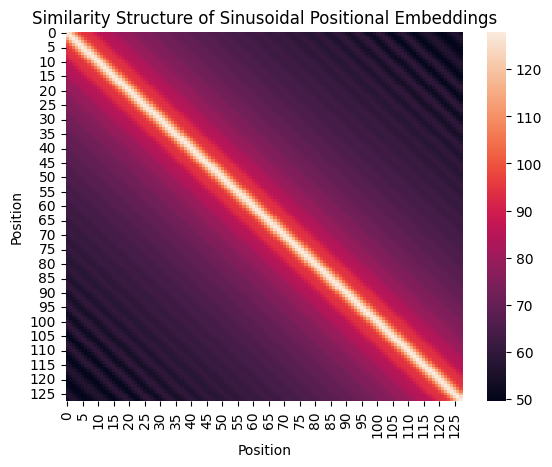

In [36]:
pe = get_sinusoidal_positional_embeddings(128, 256)

#Your code here
pe_similarity = np.dot(pe, pe.T)

sns.heatmap(pe_similarity)
plt.title('Similarity Structure of Sinusoidal Positional Embeddings')
plt.xlabel('Position')
plt.ylabel('Position')
plt.show()

### Answer to 2.2b

The diagonal is bright because the inner product of a vector with itself is the highest. There are periodic rectangles (or waves) that accurately reflect the periodic behavior of sinusoidal waves. Similarity decays as positions become farther apart, demonstrating how positional differences are effectively encoded. The goal of these embeddings is to encode the position of tokens in a sequence, providing the transformer model with a way to understand positional information. This is achieved by assigning a different sinusoidal frequency to each token, ensuring unique and distinguishable embeddings for every position.

### Multi-Head Attention

The core operation in a Transformer is multi-head attention, sometimes called self-attention. In this problem, we will implement multi-head attention in numpy from scratch, given the trained parameters of the model.

The input is a sequence of vectors $X = (x_1, ..., x_n) \in {\mathbb R}^{n \times d_{model}}$. For each attention head $h \in [n_h]$, the parameters consist of a query projection matrix $W_q^h \in {\mathbb R}^{d_{model} \times d_h}$, a key projection matrix $W_k^h \in {\mathbb R}^{d_{model} \times d_h}$, and a value projection matrix $W_k^h \in {\mathbb R}^{d_{model} \times d_h}$. Here, $d_h$ is the "head dimension", taken to be $d_{model} / n_h$ (to maintain the same dimensionality between the input and output). The algorithm, for each head, is the following:
1. Compute the queries $Q = X W_q^h$, keys $K = X W_k^h$, and values $V = X W_v^h$. Note that the linear maps are applied independently for each token across the embedding dimension (not sequence dimension), such that $Q, K, V \in {\mathbb R}^{n \times d_h}$.
2. Compare the queries and keys via inner products to get an $n \times n$ attention matrix $A = \mathrm{Softmax}(Q K^{\intercal} / \sqrt{d_h}) \in {\mathbb R}^{n \times n}$.
3. Use the attention scores $A$ to select values, producing the output of the self-attention head: $\mathrm{head}_h = A V \in {\mathbb R}^{n \times d_h}$.
We then concatenate the retrieved values across all heads, and apply a final linear map. Putting this all together yields:
$$
\begin{align}
    \mathrm{head}_h &= \mathrm{Softmax}((X W_q^h) (X W_k^h)^{\intercal}/ \sqrt{d_h}) X W_v^h\\
    \mathrm{MultiHeadAttention}(X) &= \mathrm{concat}(\mathrm{head}_1, ..., \mathrm{head}_{n_h}) W_o\\
\end{align}
$$
Note that the matrices $W_q^h$, $W_k^h$, $W_v^h$ are "packed together" across heads when you read in the parameters of the model.

### Problem 2.3: Implement multi-head attention

Complete the implementation below.

In [38]:
# first, we provide a couple of utility functions

def softmax(x, axis=-1):
    # a stable implementation of the softmax function
    exp_x = np.exp(x - np.max(x, axis=axis, keepdims=True))
    return exp_x / np.sum(exp_x, axis=axis, keepdims=True)

def apply_presoftmax_causal_mask(attn_scores):
    # apply a causal mask to the attention scores (set the entries above the diagonal to -inf)
    n = attn_scores.shape[-1]
    mask = np.triu(np.ones((n, n)), k=1)
    masked_scores = attn_scores - 1e9 * mask
    return masked_scores

def multi_head_attention(x, params, layer_prefix='layers.0'):
    """
    Compute multi-head self-attention.

    Args:
        x (np.array): input tensor, shape (n, d_model)
        params (dict): dictionary containing the model parameters
        layer_prefix (str): prefix of parameter names corresponding to the layer
        verbose (bool): whether to print intermediate shapes
    """

    # get parameters of multi-head attention layer
    wq = params[f'{layer_prefix}.attention.wq.weight'].T # (d_model, d_model)
    wk = params[f'{layer_prefix}.attention.wk.weight'].T # (d_model, d_model)
    wv = params[f'{layer_prefix}.attention.wv.weight'].T # (d_model, d_model)
    wo = params[f'{layer_prefix}.attention.wo.weight'].T # (d_model, d_model)

    head_dim = d_model // n_heads # dimension of each head
    attn_scale = 1 / math.sqrt(head_dim) # scaling factor for attention scores

    # the wq, wk, wv, wo matrices contain weights for all heads, concatenated
    # first, we split wq, wk, wv, wo into heads
    # note: there are more efficient implementations, but this is more verbose/pedagogical
    wq = wq.reshape(d_model, n_heads, head_dim).transpose(1, 0, 2) # (n_heads, d_model, head_dim)
    wk = wk.reshape(d_model, n_heads, head_dim).transpose(1, 0, 2) # (n_heads, d_model, head_dim)
    wv = wv.reshape(d_model, n_heads, head_dim).transpose(1, 0, 2) # (n_heads, d_model, head_dim)

    head_outputs = []
    for head in range(n_heads):

        # get head-specific parameters (these are the query/key/value projections for this head)
        wqh = wq[head] # (d_model, head_dim)
        wkh = wk[head] # (d_model, head_dim)
        wvh = wv[head] # (d_model, head_dim)

        # compute queries, keys, values
        # your code here
        q = np.dot(x, wqh) # (n, head_dim)
        k = np.dot(x, wkh) # (n, head_dim)
        v = np.dot(x, wvh) # (n, head_dim)

        # compute attention scores
        # your code here
        attn_scores = np.dot(q, k.T) # (n, n)

        attn_scores = apply_presoftmax_causal_mask(attn_scores)
        attn_scores = softmax(attn_scores * attn_scale, axis=-1) # (n, n)

        # apply attention scores to values
        # your code here
        head_out = np.dot(attn_scores, v)  # (n, head_dim)

        # store the head output
        head_outputs.append(head_out)

    # concatenate all head outputs
    head_outputs = np.concatenate(head_outputs, axis=-1) # (n, d_model)

    # apply output linear map W_o to concatenated head outputs
    # your code here
    output = np.dot(head_outputs, wo)  # (n, d_model)

    return output

### Problem 2.4: Test your Attention implementation

To test if you have the correct implementation, you can run the following 
test line. We show the expected output if your implementation is correct.

In [39]:
multi_head_attention(np.ones((block_size, d_model)), transformer_model_weights)[:3, :5]

array([[ 0.48334133,  0.19740422, -0.39514927, -0.40647455,  0.4831646 ],
       [ 0.48334133,  0.19740422, -0.39514927, -0.40647455,  0.4831646 ],
       [ 0.48334133,  0.19740422, -0.39514927, -0.40647455,  0.4831646 ]])

Expected output:

```
array([[ 0.48334133,  0.19740422, -0.39514927, -0.40647455,  0.4831646 ],
       [ 0.48334133,  0.19740422, -0.39514927, -0.40647455,  0.4831646 ],
       [ 0.48334133,  0.19740422, -0.39514927, -0.40647455,  0.4831646 ]])

```

### MLP

Each Transformer layer (i.e., block) consists of two operations: 1) (multi-head) self-attention, which enables exchange of information between tokens, and 2) a multi-layer perceptron, which processes each token independently. A Transformer model is essentially just alternating between these two operations. In this problem, we will implement the multi-layer perceptron step. Typically, the MLP at each layer is simply a two-layer (one hidden layer) MLP or Feed Forward Network. In our model, we use a ReLU activation in the hidden layer, though other activations are possible. The same MLP network is applied to each token embedding in the sequence independently. 

Given $X = (x_1, ..., x_n) \in {\mathbb R}^{n \times d_{model}}$, we apply the MLP as follows:

$$\mathrm{MLP}(X) = \mathrm{ReLU}(X W_1) W_2$$

Note that we don't use biases for simplicity.

### Problem 2.5: Implement the MLP

Next, we need to apply the multi-layer perceptron in each layer. Complete the implementation below.

In [40]:
def relu(x):
    return np.maximum(x, 0)

def mlp(x, params, layer_prefix='layers.0'):
    # get MLP parameters
    w1 = params[f'{layer_prefix}.feed_forward.0.weight'].T # (d_model, d_ff)
    w2 = params[f'{layer_prefix}.feed_forward.2.weight'].T # (d_ff, d_model)

    # Your code here 
    h = relu(np.dot(x, w1))
    o = np.dot(h, w2) # (n, d_model)

    return o

### Problem 2.6: Test your MLP implementation

To test if you have the correct MLP implementation, you can run the following 
test line. We show the expected output if your implementation is correct.

In [41]:
mlp(np.ones((block_size, d_model)), transformer_model_weights)[:3, :5]

array([[0.06068574, 0.6727857 , 0.20872724, 0.42208509, 0.29517956],
       [0.06068574, 0.6727857 , 0.20872724, 0.42208509, 0.29517956],
       [0.06068574, 0.6727857 , 0.20872724, 0.42208509, 0.29517956]])

Expected output:

```
array([[0.06068574, 0.6727857 , 0.20872724, 0.42208509, 0.29517956],
       [0.06068574, 0.6727857 , 0.20872724, 0.42208509, 0.29517956],
       [0.06068574, 0.6727857 , 0.20872724, 0.42208509, 0.29517956]])
```

### Final Prediction Layer

A Transformer model iteratively applies multi-head attention and MLP layers to process the input. This produces a processed representation of shape $n \times d_{model}$. To make the final prediction (e.g., predict the next token), we need to map the $d_{model}$-dimensional embedding vectors to logits over the output vocabulary. To do this, we simply apply a linear map that maps from $d_{model}$ to $\mathtt{vocab\_size}$.

The starter code for this is given below; you need to complete it.

### Problem 2.7: Implement the prediction layer as logits.

In [42]:
def prediction_head(x, params):
    # get needed parameters
    w = params['fc_out.weight'].T # (d_model, vocab_size)
    b = params['fc_out.bias'] # (vocab_size,)

    # Your code here
    logits = np.dot(x, w) + b # (n, vocab_size)

    return logits

### Problem 2.8: Test the prediction head

In [43]:
prediction_head(np.ones((block_size, d_model)), transformer_model_weights)[:3, :5]

array([[ 0.88448969,  0.07200013, -0.67318526, -1.11558351,  0.14410351],
       [ 0.88448969,  0.07200013, -0.67318526, -1.11558351,  0.14410351],
       [ 0.88448969,  0.07200013, -0.67318526, -1.11558351,  0.14410351]])

```
array([[ 0.88448969,  0.07200013, -0.67318526, -1.11558351,  0.14410351],
       [ 0.88448969,  0.07200013, -0.67318526, -1.11558351,  0.14410351],
       [ 0.88448969,  0.07200013, -0.67318526, -1.11558351,  0.14410351]])

```

### Putting it all together: A Full Transformer Language Model

We are now ready to put this all together to assemble our Transformer Language Model. Recall that the Transformer architecture consists of iteratively applying multi-head attention and MLPs. Each time we apply attention or the MLP, we also apply a *residual connection*: $X^{(\ell + 1)} = X^{(\ell)} + F(X^{(\ell)})$. This can be interpreted as a mechanism to enable easy communication between different layers (some people call refer to this idea as the "residual stream"). Real Transformers also include layer normalization in each layer, but we omit this for simplicity in this problem.

The full algorithm is given below:
1. Embed the tokens using the embedding lookup table: $(t_1, ..., t_n) \mapsto (E_{t_1}, ..., E_{t_n}) =: X^{(0)}$
2. Add the positional embeddings: $X^{(0)} \gets X^{(0)} + (PE_1, ..., PE_n)$
3. For each layer $\ell = 1, ..., L$:
    1. Apply Multi-Head Attention: $\tilde{X}^{(\ell)} \gets X^{(\ell-1)} + \mathrm{MultiHeadAttention}(X^{(\ell-1)})$.
    2. Apply the MLP: $X^{(\ell)} \gets \tilde{X}^{(\ell)} + \mathrm{MLP}(\tilde{X}^{(\ell)})$.
4. Compute the logits

### Problem 2.9: Complete the implementation

Complete the starter code below, which takes embeddings, adds positional encoding, 
and then adds the attention and MLP components to each layer. Remember that 
everything is added together, with the computations in one layer added to the outputs of the previous layer, forming the "residual stream".

In [46]:
def transformer(tokens, params):
    # tokens: (n,) integer array
    # params: dictionary of parameters

    # map tokens to embeddings using embed_tokens
    x = embed_tokens(tokens, params)  # (n, d_model)

    # add positional embeddings
    pe = get_sinusoidal_positional_embeddings(x.shape[0], x.shape[1]) # (n, d_model)
    # your code here
    x = x + pe

    # transformer blocks
    for i in range(n_layers):

        # compute multi-head self-attention and add residual
        # your code here
        attn_out = multi_head_attention(x, params, layer_prefix=f'layers.{i}') # (n, d_model)
        # your code here
        x = x + attn_out

        # compute MLP and add residual
        mlp_out = mlp(x, params, layer_prefix=f'layers.{i}') # (n, d_model)
        # your code here
        x = x + mlp_out

    # compute logits via the prediction_head
    # your code here
    logits = prediction_head(x, params) # (n, vocab_size)

    return logits

### Problem 2.10: Test your implementation

You can check your implementation against the expected output below.

In [49]:
transformer([0, 1, 2], params=transformer_model_weights)[:3, :5]

array([[-1.9641349 , -5.12566872, -5.90677718, -5.57889839, -3.85043564],
       [-2.31297379, -4.9703405 , -3.49086668, -5.3996587 , -3.99684942],
       [-2.97001726, -4.84049568, -4.04949194, -4.01892107, -6.03805991]])

Expected Output:

```
array([[-1.96413494, -5.12566872, -5.90677725, -5.57889829, -3.85043572],
       [-2.31297382, -4.97034061, -3.49086669, -5.39965866, -3.99684957],
       [-2.97001738, -4.8404957 , -4.04949199, -4.01892112, -6.03806011]])
```

### Generate some text

Below, we provide some code for generating text from a Transformer language model. The sampling procedure is *autoregressive*. This means that we input some text to the model and it outputs a distribution over next tokens. We sample the next token and append it to the text, then repeat the procedure.

### Problem 2.11: Complete the next token generator

Complete the next token generator, but filling in the missing code below. This uses "temperature" to focus on the more probable tokens in a given context (as the temperature decreases). This results in sampling according to 
$ \mathrm{Softmax}(\mathrm{logits}/T)$ where $T \geq 0$ is the temperature; lower temperature places higher probability on tokens having larger logits. Greedy sampling corresponds to $T=0$, and selects the token with the largest logit.

In [51]:
def generate_with_transformer(prefix_text, params, max_len=128, greedy=False, temperature=0.9):
    # encode seed text
    prefix_tokens = list(enc.encode(prefix_text))

    # initialize generated tokens
    generated_tokens = prefix_tokens

    # generate new tokens
    for i in range(max_len):
        # predict next token
        logits = transformer(generated_tokens, params)
        # logits[-1] corresponds to prediction of the next token
        next_logits = logits[-1]
        
        if greedy:
            # Your code here
            next_token = np.argmax(next_logits)
        else:
            # Your code here
            scaled_logits = next_logits / temperature
            probabilities = np.exp(scaled_logits) / np.sum(np.exp(scaled_logits))
            next_token = np.random.choice(len(probabilities), p=probabilities)

        # add next token to generated tokens
        generated_tokens.append(next_token)

    # This converts the tokens to text, using the tiktoken decoder:
    generated_text = enc.decode(generated_tokens)

    return generated_text

### Problem 2.12: Test your implementation by generating text. You're the Bard!

Use your implementation to generate text according to the model. Generate text at different temperatures. Do the results make sense? Comment on the quality of the model. What changes to the model would lead to better results? Comment in the Markdown cell below.

In [52]:
prefix_text = """ANTONIO:
Do you not hear me speak?"""

generated_text = generate_with_transformer(prefix_text, transformer_model_weights, greedy=True, max_len=128)
print(generated_text)

ANTONIO:
Do you not hear me speak?

First Citizen:
We cannot

First Citizen:
He that hath done fell, sir, sir, sir, sir, sir, sir, sir, sir,
Which ne'er could the belly answer'd--
Which you,
Which you shall fell'd:
Which you shall tell you'll hear it smile, Iliber,
Which ne'--it it belly taunted head the belly,
MENENIUS:
There answer'd, you'll have lusedup
'
There


In [53]:
prefix_text = """ANTONIO:
Do you not hear me speak?"""

generated_text = generate_with_transformer(prefix_text, transformer_model_weights, greedy=False, temperature=0.8, max_len=128)
print(generated_text)

ANTONIO:
Do you not hear me speak?


First Citizen:
MENENIUS:
The sen, what senenenators of Rome are this good belly,
First Citizen:
The countrymenenenenebly like a gen though so!
Which the belly,
Sir counsed it did mute, the midst o' the body.



MENENIUS:
Sselly's answer?
Our bashould by the belly,
Sir, I shall tell you
First C


In [57]:
prefix_text = """ANTONIO:
Do you not hear me speak?"""

generated_text = generate_with_transformer(prefix_text, transformer_model_weights, greedy=False, temperature=0.1, max_len=250)
print(generated_text)

ANTONIO:
Do you not hear me speak?

First Citizen:
We cannot
First Citizen:
MENENIUS:
The senators of Rome are this good belly,
And you the mutinous members; for examine
Their counsels and their cares, digest things rightly
Touching the weal o' the common, you shall find
No public benefit which you receive
But it proceeds or comes from them to you
And no way from them to you
And no way from them to you
And no way from them to you do you do you do you
And no way from them to food at the greatness that they live: but the commons or comes from them to you
And no way from them asse courty toe of this asse will flour with being one o' What then? What do you do you think, the great to you care fort them as you do you could you
And no subling the commons or comes from them to you could yieve


In [58]:
prefix_text = """ANTONIO:
Do you not hear me speak?"""

generated_text = generate_with_transformer(prefix_text, transformer_model_weights, greedy=False, temperature=0.8, max_len=250)
print(generated_text)

ANTONIO:
Do you not hear me speak?
Pats, we'll hear it side o' the common
First Citizen:
Pating here?
First Citizen:
Their countrymor heart could belly, I shall famine

They answer a timeed head, I shall famselly, I shall fell'd--
'-- taunting the leg, famine
MENENIUS:
Sir, what smile,
As well as speak--of the belly's answer could by the muthould you receive that
Which ne'From me do deed his nat o'-- that delieds and thus-- muth like a luselly's answeringly replile and thus--
Or belly's answer came from in hand?
There I will vigestame from thus-- mutinous partic body's answer came from the belly's answer came from the belly particior ice did remain we might gain


### Problem 2.12
The results demonstrate that the model performs reasonably well in generating Shakespearean text. Adjusting the temperature parameter shows that lower values lead to outputs resembling greedy decoding, where the model consistently predicts tokens like "sir," likely due to its frequent use in Shakespeare's works. Higher temperatures introduce more randomness, resulting in text that feels less Shakespearean and more like the model's unique interpretation. Experimenting with max_len highlights the transformer's ability to generate longer and more coherent text compared to vanilla RNNs, though some incoherence remains.

To improve performance, the model could benefit from an increased size, as it currently has only 4 layers, whereas models like BERT and modern LLMs use 12 and upwards of 128 layers, respectively. Expanding the training dataset would also enhance the model’s understanding of context and vocabulary. Finally, fine-tuning the model on downstream tasks with supervised prompts could further improve its ability to generate coherent and contextually appropriate text.